# ADQL Query examples

<br>
<br>


<img style="position: absolute; right: 60px; top: 40px; height: 160px; width: 160px" src="https://datalabs.esa.int/datalab-icon/c11e47af-7ce9-4281-b3b5-475a180a256f" /> 


**Author(s):** Héctor Cánovas Cabrera

**Last modified:** 14.03.2025

**Notebook summary**

This notebook includes the ADQL Query examples that are directly accessible from the Euclid Archive WEB interface.

1. To facilitate the navigation through this notebook, only the first 3 lines of the retrieved tables are displayed when the downloaded table contains > 10 rows. This can be easily adjusted or modified below.
2. The ADQL queries are designed to not exceed 1 minute execution time. Currently, most queries are finished in <5 seconds, but their execution time once PDR is public will increase.
3. the ADQL queries are set using the [Python f-string](https://docs.python.org/3/tutorial/inputoutput.html). This approach improves the user experience as it allows to easily modify the optional parts of the query. At the same time, I have tried to not "abuse" of this utility to balance the readibility and interactivity of the examples.

**Some useful links:**
* [Euclid Q1 data product description](https://euclid.esac.esa.int/dr/q1/dpdd/index.html)
* [Astroquery.Euclid latest documentation content](https://astroquery--3216.org.readthedocs.build/en/3216/esa/euclid/euclid.html)
* [Astroquery.Euclid latest help content](https://astroquery--3216.org.readthedocs.build/en/3216/api/astroquery.esa.euclid.EuclidClass.html)
* [Astropy table documentation](https://docs.astropy.org/en/stable/table/index.html)
* [TAP and ADQL beginner tutorial for Rubin](https://dp0-2.lsst.io/_static/nb_html/DP02_02a_Introduction_to_TAP.html)

**Running the notebook:** This notebook has **read-only permissions**. You can still run and edit cells but if you would like to save your changes then you have to save the notebook to a different location - your workspace for example. The notebook is intended to be run using the **EUCLID-TOOLS kernel** that has all the necessary packages included.

***

In [1]:
# installing necessary packages
from astroquery.esa.euclid.core import EuclidClass
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import os

In [2]:
# making a folder for the output files
output_folder= '/media/user/example_notebook_outputs/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
# logging in
Euclid = EuclidClass(environment='PDR')

# loggin in using a credential file
Euclid.login(credentials_file='/media/user/cred.txt')

# logging in without the credential file
# Euclid.login(user='yourusername') 

INFO: Login to Euclid TAP server: eas.esac.esa.int:443/tap-server/tap/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service: eas.esac.esa.int:443/sas-dd/tap-server/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service: eas.esac.esa.int:443/sas-cutout/tap-server/ [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


## 1. Cone search around NGC 6505 ("Altieri's ring") using a 0.1 degrees radius

Output size (#rows): 15,129

In [4]:
inp_coords = [267.78, 65.53] # RA & Dec - it can be updated as needed
inp_rad    = 0.1             # Cone search radius in degrees - it can be updated as needed

query = f"""SELECT right_ascension, declination, object_id, vis_det, det_quality_flag, flux_detection_total, flux_vis_sersic, flux_y_sersic, flux_j_sersic, flux_h_sersic,
segmentation_map_id, segmentation_area, kron_radius, DISTANCE({inp_coords[0]}, {inp_coords[1]}, right_ascension, declination) AS dist
FROM mer_catalogue
WHERE DISTANCE({inp_coords[0]}, {inp_coords[1]}, right_ascension, declination) < {inp_rad}"""

job = Euclid.launch_job_async(query)
res = job.get_results()
res[0:3]

INFO: Query finished. [astroquery.utils.tap.core]


right_ascension,declination,object_id,vis_det,det_quality_flag,flux_detection_total,flux_vis_sersic,flux_y_sersic,flux_j_sersic,flux_h_sersic,segmentation_map_id,segmentation_area,kron_radius,dist
float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,int64,int64,float64,float64
267.8007183299202,65.43077069259559,2678007183654307706,1,2,3.303119659423828,3.1258363723754883,8.079318046569824,10.060230255126953,13.103922843933105,102158889039947,257,24.9636173248291,0.09960112595660932
267.81347229955026,65.43376784423499,2678134722654337678,1,0,0.2972785234451294,0.2499639391899109,0.6006065607070923,0.45541542768478394,0.758150041103363,102158889040543,53,18.347612380981445,0.09722946762358776
267.73787120423793,65.43489754122781,2677378712654348975,1,0,0.08075621724128723,0.10290417075157166,0.2827775776386261,0.3062794506549835,0.34649279713630676,102158889040707,14,6.5500030517578125,0.0966959477506201


## 2. Photometric redshift classification in a 0.1 degrees radius centred on NGC 6505 ("Altieri's ring")

Output size (#rows): 15,129

In [5]:
inp_coords = [267.78, 65.53] # RA & Dec - it can be updated as needed
inp_rad    = 0.1             # Cone search radius in degrees - it can be updated as needed

query = f"""SELECT mer.right_ascension, mer.declination, phz_class.*
FROM mer_catalogue AS mer
JOIN phz_classification AS phz_class USING (object_id)
WHERE DISTANCE({inp_coords[0]}, {inp_coords[1]}, mer.right_ascension, mer.declination) < {inp_rad}"""

job = Euclid.launch_job_async(query)
res = job.get_results()
res[0:3]

INFO: Query finished. [astroquery.utils.tap.core]


right_ascension,declination,basic_download_data_oid,missing_band,qso_threshold,to_be_published,vis_det,object_id,configuration,phz_star_prob,phz_gal_prob,phz_qso_prob,phz_glob_cl_prob,phz_classification,star_threshold,galaxy_threshold,globc_threshold
float64,float64,int64,str54,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64
267.9658741148234,65.5880798686669,23866,--,0.6686867719176105,1,0,2679658741655880798,30,0.6032757759094238,0.24296845495700836,0.6141918301582336,0.0,3,0.5814304686280756,0.22049536645892448,1.0
268.0044949594842,65.5610547037996,23866,--,0.6686867719176105,1,0,2680044949655610547,30,0.02861104905605316,0.6079207062721252,0.3748030960559845,0.0,2,0.5814304686280756,0.22049536645892448,1.0
267.9937991559214,65.55876675778072,23866,--,0.6686867719176105,1,0,2679937991655587667,30,0.006781744305044413,0.9100964665412903,0.15001347661018372,0.0,2,0.5814304686280756,0.22049536645892448,1.0


## 3. Count candidate stars in the phz_star_sed catalogue

Output size (#rows): 1

In [6]:
threshold = 0.9             # Probability threshold - it can be updated as needed
inp_table = 'phz_star_sed'  # Target table          - it can be updated as needed

query = f"""SELECT count(*)
FROM {inp_table}
WHERE phz_star_prob > {threshold}"""

job = Euclid.launch_job_async(query)
res = job.get_results()
res

INFO: Query finished. [astroquery.utils.tap.core]


COUNT_ALL
int64
328999


## 4. Select 10 sources with relative spectral redshift error < 10% 

Output size (#rows): 10

In [7]:
threshold = 10.0 # Redshift signal to noise - it can be updated as needed

query = f"""SELECT TOP 10 cat1.right_ascension, cat1.declination, cat1.point_like_prob, cat1.det_quality_flag, cat1.spurious_flag,
cat1.flux_detection_total, cat1.mumax_minus_mag, cat1.vis_det, cat1.flux_vis_2fwhm_aper, cat2.spe_z, cat2.spe_z_err
FROM mer_catalogue as cat1
JOIN spectro_zcatalog_spe_galaxy_candidates AS cat2 USING(object_id)
WHERE cat2.spe_z/cat2.spe_z_err > {threshold}"""

job = Euclid.launch_job_async(query)
res = job.get_results()
res

INFO: Query finished. [astroquery.utils.tap.core]


right_ascension,declination,point_like_prob,det_quality_flag,spurious_flag,flux_detection_total,mumax_minus_mag,vis_det,flux_vis_2fwhm_aper,spe_z,spe_z_err
float64,float64,float64,int64,int64,float64,float64,int64,float64,float64,float64
57.0597059613122,-49.35229627054168,5.119985871715471e-06,0,0,2.513490676879883,0.1746654510498047,1,1.5146058797836304,4.829611301422119,0.0016689581098034978
57.0597059613122,-49.35229627054168,5.119985871715471e-06,0,0,2.513490676879883,0.1746654510498047,1,1.5146058797836304,4.910617828369141,0.0033870330080389977
57.0597059613122,-49.35229627054168,5.119985871715471e-06,0,0,2.513490676879883,0.1746654510498047,1,1.5146058797836304,1.4521135091781616,0.0004529160796664655
57.0597059613122,-49.35229627054168,5.119985871715471e-06,0,0,2.513490676879883,0.1746654510498047,1,1.5146058797836304,4.970020294189453,0.003729436080902815
273.8136619604732,66.57758193578172,--,0,0,2.8808138370513916,-0.5323467254638672,0,0.1238514631986618,4.9082536697387695,0.0033993907272815704
273.8136619604732,66.57758193578172,--,0,0,2.8808138370513916,-0.5323467254638672,0,0.1238514631986618,2.9890389442443848,0.0006752391345798969
273.8136619604732,66.57758193578172,--,0,0,2.8808138370513916,-0.5323467254638672,0,0.1238514631986618,4.949162006378174,0.0021036751568317413
273.8136619604732,66.57758193578172,--,0,0,2.8808138370513916,-0.5323467254638672,0,0.1238514631986618,4.7658371925354,0.004342198371887207
273.8136619604732,66.57758193578172,--,0,0,2.8808138370513916,-0.5323467254638672,0,0.1238514631986618,4.852976322174072,0.003136466955766082


## 5. Select top 20 brightest sources by flux_vis_sersic

Output size (#rows): 20

In [8]:
query = f"""SELECT TOP 20 right_ascension, declination, flux_vis_4fwhm_aper, flux_vis_psf, flux_vis_sersic, flux_detection_total, det_quality_flag, spurious_flag, vis_det
FROM mer_catalogue
WHERE NULLIF(flux_vis_sersic, 'NaN') > 0.0
ORDER BY flux_vis_sersic DESC"""

job = Euclid.launch_job_async(query)
res = job.get_results()
res[0:3]

INFO: Query finished. [astroquery.utils.tap.core]


right_ascension,declination,flux_vis_4fwhm_aper,flux_vis_psf,flux_vis_sersic,flux_detection_total,det_quality_flag,spurious_flag,vis_det
float64,float64,float64,float64,float64,float64,int64,int64,int64
269.6384206860493,66.63371280343897,165761.546875,410.2769775390625,524987.3125,524965.5625,898,0,1
56.83184245323367,-50.75447754356855,--,--,462965.875,462965.625,394,0,1
269.64082630830296,66.63333314039146,--,--,452177.5,452328.71875,1920,0,0


## 6. Cone search to obtain the spectra (which can be downloaded via DataLink) of objects with 1 < z < 1.1 around a given position

Output size (#rows): 155
Note: this ADQL query contains three fields (datalabs_path, file_name, hdu_index) not included in the ADQL examples available in the WEB interface of the Euclid Archive. These fields are most relevant for users aiming to access the
spectra programmatically and mainly from ESA datalabs.

In [9]:
inp_coords = [75.0, -45.0]   # RA & Dec - it can be updated as needed
inp_rad    = 6.0             # Cone search radius in degrees - it can be updated as needed

query= f"""SELECT spec.ra_obj, spec.dec_obj, spec.source_id, spec.datalabs_path, spec.file_name, spec.hdu_index, phz.phz_median, mer.flux_h_4fwhm_aper
FROM spectra_source AS spec
JOIN phz_photo_z AS phz
  ON spec.source_id = phz.object_id
JOIN mer_catalogue AS mer
  ON spec.source_id = mer.object_id
AND phz.phz_median BETWEEN 1.0 AND 1.1
AND DISTANCE(ra_obj, dec_obj, {inp_coords[0]}, {inp_coords[1]}) < {inp_rad}
ORDER BY ra_obj ASC"""

job = Euclid.launch_job_async(query)
res = job.get_results()
res[0:3]

INFO: Query finished. [astroquery.utils.tap.core]


ra_obj,dec_obj,source_id,datalabs_path,file_name,hdu_index,phz_median,flux_h_4fwhm_aper
float64,float64,int64,str35,str61,int64,float64,float64
66.7048678897113,-46.5969878285092,-667048678465969878,/data/euclid_q1/Q1_R1/SIR/102022982,EUC_SIR_W-COMBSPEC_102022982_2024-11-01T16:05:20.960184Z.fits,1445,1.059999942779541,4.68186092376709
66.7172228661413,-46.6359663129147,-667172228466359663,/data/euclid_q1/Q1_R1/SIR/102022982,EUC_SIR_W-COMBSPEC_102022982_2024-11-01T16:05:10.171991Z.fits,1401,1.0,6.671435356140137
66.7217519274094,-46.6546784378331,-667217519466546784,/data/euclid_q1/Q1_R1/SIR/102022982,EUC_SIR_W-COMBSPEC_102022982_2024-11-01T16:05:06.017957Z.fits,1535,1.0399999618530273,34.7795295715332


### 6.1 Retrieve the spectra of the second source via DataLink


In [12]:
from datetime import datetime as dt
inp_row = 1     # To retrieve the spectra associated to the second row in the output of the query above

inp_source_id = res['source_id'][inp_row]
dl_out = Euclid.get_spectrum(source_id=f"{inp_source_id}", retrieval_type = "SPECTRA_RGS",  output_file = output_folder + "/spectra_" + dt.now().strftime('%Y-%m-%d_%H:%M:%S') + "/temp.fits.zip", verbose = True)
print()
print(f'Spectra downloaded and saved in: {dl_out[0]}')

output file: /media/user/example_notebook_outputs//spectra_2025-03-17_15:03:16/temp.fits.zip
Retrieving data.
Data request: ID=sedm+-667172228466359663&SCHEMA=sedm&RETRIEVAL_TYPE=SPECTRA_RGS&USE_ZIP_ALWAYS=true&TAPCLIENT=ASTROQUERY
------>https
host = eas.esac.esa.int:443
context = /sas-dd/data
Content-type = application/x-www-form-urlencoded
200 
Reading...
Done.

Spectra downloaded and saved in: /media/user/example_notebook_outputs//spectra_2025-03-17_15:03:16/SPECTRA_RGS-sedm -667172228466359663.fits


In [14]:
spec_dl = fits.open(dl_out[0]) # This contains two HDUs, we are interested in the 2nd one.
spec_dl = spec_dl[1]
spec_dl.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   22 / width of table in bytes                        
NAXIS2  =                  531 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    6 / number of fields in each row                   
TTYPE1  = 'WAVELENGTH'         / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TUNIT1  = 'Angstrom'           / physical unit of field                         
TTYPE2  = 'SIGNAL  '           / label for field   2                            
TFORM2  = '1E      '        

### 6.2 Retrieve the spectra of the first source_id from the FITS files stored in Datalabs

To that end we use the information included in the "datalabs_path", "file_name", and "hdu_index" fields.

In [15]:
fits_file_path = res[inp_row]['datalabs_path'] + '/' + res[inp_row]['file_name']
hdu = res[inp_row]['hdu_index']

temp = fits.open(fits_file_path) # This contains two HDUs, we are interested in the 2nd one.
print(f'* Reading {fits_file_path}: {len(temp):,} HDUs found')
print(f'* Extracting spectra associated to HDU = {hdu}')
print()

spec_datalabs  = temp[hdu]
spec_datalabs.header

* Reading /data/euclid_q1/Q1_R1/SIR/102022982/EUC_SIR_W-COMBSPEC_102022982_2024-11-01T16:05:10.171991Z.fits: 2,279 HDUs found
* Extracting spectra associated to HDU = 1401



XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   22 / width of table in bytes                        
NAXIS2  =                  531 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    6 / number of fields in each row                   
TTYPE1  = 'WAVELENGTH'         / label for field   1                            
TFORM1  = '1E      '           / data format of field: 4-byte REAL              
TUNIT1  = 'Angstrom'           / physical unit of field                         
TTYPE2  = 'SIGNAL  '           / label for field   2                            
TFORM2  = '1E      '        

### 6.3 Plot both spectra

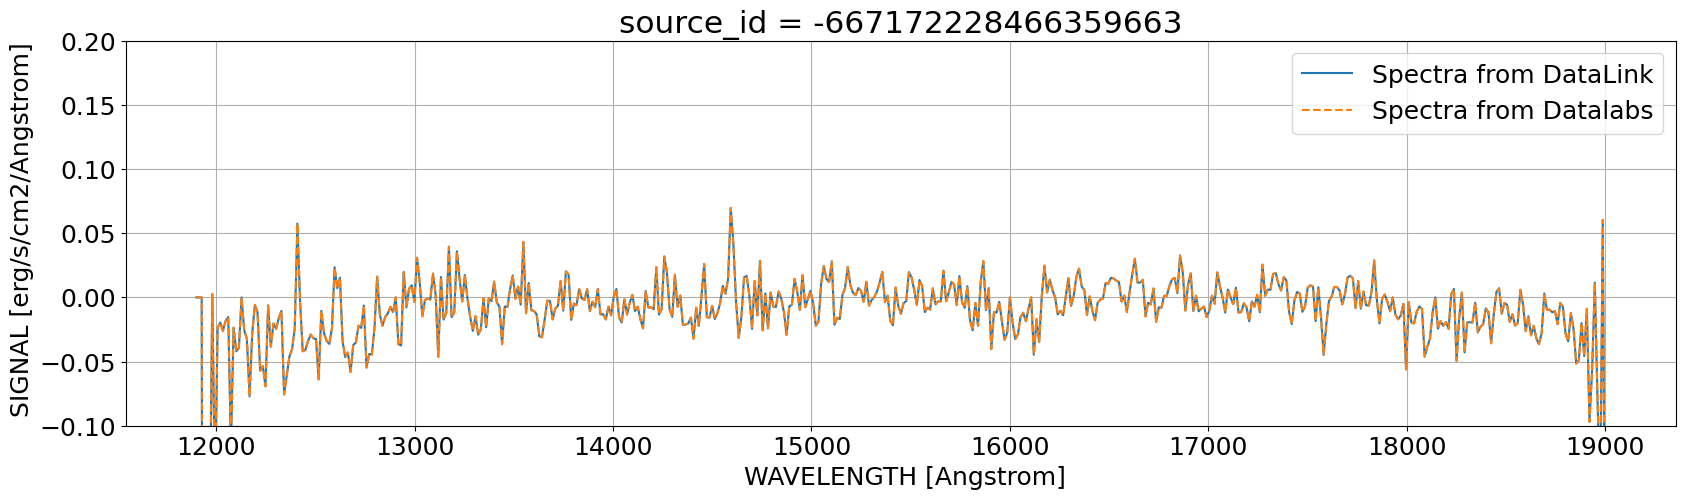

In [16]:
fontsize = 18
fig      = plt.figure(figsize=[20,5])
plt.title(f'source_id = {inp_source_id}', fontsize = fontsize*1.25)
plt.plot(spec_dl.data['WAVELENGTH'],       spec_dl.data['SIGNAL'],       label = 'Spectra from DataLink')
plt.plot(spec_datalabs.data['WAVELENGTH'], spec_datalabs.data['SIGNAL'], label = 'Spectra from Datalabs', linestyle = '--')

plt.legend(fontsize = fontsize)
plt.grid()
plt.ylim([-0.1,0.2])
plt.xlabel(f" WAVELENGTH [{spec_dl.header['TUNIT1']}]" , fontsize = fontsize)
plt.ylabel(f" SIGNAL [{spec_dl.header['TUNIT2']}]" , fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.show()

## 7. Get mosaic information (like tile_index) for the VIS observations that include a selected target by coordinates

Output size (#rows): 3

In [17]:
inp_coords = [267.78, 65.53] # RA & Dec - it can be updated as needed
inp_rad    = 0.5             # Cone search radius in degrees - it can be updated as needed


query = f"""SELECT *, DISTANCE(ra, dec, {inp_coords[0]}, {inp_coords[1]}) AS dist
FROM mosaic_product
WHERE DISTANCE({inp_coords[0]}, {inp_coords[1]}, ra, dec) < {inp_rad}
AND instrument_name = 'VIS'"""

job = Euclid.launch_job_async(query)
res = job.get_results()
res

INFO: Query finished. [astroquery.utils.tap.core]


category,checksum,creation_date,crpix1,crpix2,crval1,crval2,datalabs_path,data_release_oid,data_size,dec,file_name,file_path,filter_name,first_type,fov,instrument_name,mosaic_product_oid,patch_id_list,product_id,product_type,provenance_id,published,ra,release_date,release_name,second_type,stc_s,technique,tile_index,to_be_published,zero_point,zero_point_error,dist
str7,str32,str23,float64,float64,float64,float64,str39,int64,float64,float64,str80,str51,str3,str3,str153,str3,int64,int64,str110,str15,int64,int64,float64,int64,str5,str3,str161,str5,int64,int64,float64,float64,float64
SCIENCE,e85b41d774e5c3f2d6b7190e4908266c,2024-10-26T02:27:42.475,9600.0,9600.0,268.5638797,65.5,/data/euclid_q1/Q1_R1/MER/102158890/VIS,1,-32.0,65.5,EUC_MER_BGSUB-MOSAIC-VIS_TILE102158890-A009F7_20241025T033856.531554Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158890/VIS,VIS,STD,"(269.2003326258326, 65.23201832676949, 267.92736047553643, 65.2320180465897, 267.914226922229, 65.76528616417983, 269.21346481140546, 65.765286451356)",VIS,2498,49,MER_ProcessTile_EUCLID_2.0.2-QUICK_RELEASE-glibet-PLAN-000003-G86WZ5QR-20241024-174840-49-compressed_mosaics-0,DpdMerBksMosaic,5,0,268.5638797,--,Q1_R1,SKY,Polygon J2000 269.2003326258323 65.23201832676932 267.9273604755362 65.23201804658949 267.91422692222915 65.76528616418001 269.2134648114055 65.76528645135625,IMAGE,102158890,1,24.6,0.1,0.3262628896197043
SCIENCE,36ca4ab532a46e29e2afc1a2927b1502,2024-10-26T00:02:28.889,9600.0,9600.0,267.6677326,66.0,/data/euclid_q1/Q1_R1/MER/102159190/VIS,1,-32.0,66.0,EUC_MER_BGSUB-MOSAIC-VIS_TILE102159190-6E6EF8_20241025T010045.358775Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102159190/VIS,VIS,STD,"(268.3164801839071, 65.7319868835704, 267.01891743695654, 65.73198659683939, 267.0052112445985, 66.26525338744666, 268.33018494891104, 66.26525368145022)",VIS,2260,49,MER_ProcessTile_EUCLID_2.0.2-QUICK_RELEASE-glibet-PLAN-000003-MTFDNLIH-20241024-174840-61-compressed_mosaics-0,DpdMerBksMosaic,5,0,267.6677326,--,Q1_R1,SKY,Polygon J2000 268.31648018390734 65.73198688357043 267.01891743695654 65.73198659683952 267.00521124459834 66.26525338744648 268.33018494891104 66.26525368145018,IMAGE,102159190,1,24.6,0.1,0.4722536433950644
SCIENCE,7ea902effed19bf370bbdeb76cd5d99b,2024-10-26T12:57:21.177,9600.0,9720.0,267.3807789,65.4983,/data/euclid_q1/Q1_R1/MER/102158889/VIS,1,-32.0,65.4983,EUC_MER_BGSUB-MOSAIC-VIS_TILE102158889-F95D3B_20241025T024806.508980Z_00.00.fits,/euclid/repository_idr/iqr1/Q1_R1/MER/102158889/VIS,VIS,STD,"(268.01711050138965, 65.22698537773368, 266.74438101261455, 65.22698509761862, 266.7310851576081, 65.76691932015984, 268.0304049717605, 65.7669196073578)",VIS,1963,49,MER_ProcessTile_EUCLID_2.0.2-QUICK_RELEASE-glibet-PLAN-000003-UJ5F2ZOF-20241024-174840-48-compressed_mosaics-0,DpdMerBksMosaic,5,0,267.3807789,--,Q1_R1,SKY,Polygon J2000 268.01711050138994 65.22698537773358 266.7443810126148 65.22698509761858 266.73108515760794 65.76691932015997 268.03040497176073 65.76691960735793,IMAGE,102158889,1,24.6,0.1,0.1684734751975338


## 8. Photometric object classification for the sources that are likely galaxies detected in tile_index = 102158889

Output size (#rows): 48,211

In [18]:
tile_index = 102158889   # Tile index - it can be updated as needed
threshold  = 0.8         # Cone search radius in degrees - it can be updated as needed


query = f"""SELECT mer_cat.right_ascension, mer_cat.declination, mer_cat.segmentation_map_id, phz_class.object_id, phz_class.phz_star_prob, phz_class.phz_gal_prob, phz_class.phz_qso_prob
FROM mer_catalogue AS mer_cat
JOIN phz_classification AS phz_class USING (object_id)
WHERE mer_cat.segmentation_map_id / 1000000 = {tile_index} AND phz_class.phz_gal_prob > {threshold}
ORDER BY phz_class.phz_gal_prob DESC"""

job = Euclid.launch_job_async(query)
res = job.get_results()
res[0:3]

INFO: Query finished. [astroquery.utils.tap.core]


right_ascension,declination,segmentation_map_id,object_id,phz_star_prob,phz_gal_prob,phz_qso_prob
float64,float64,int64,int64,float64,float64,float64
267.0494003738635,65.42513695491766,102158889038866,2670494003654251369,0.0036846355069428682,0.974372923374176,0.013928661122918129
267.90565528915926,65.30418404902605,102158889015074,2679056552653041840,0.0029265524353832006,0.9740169048309326,0.013928661122918129
267.71898144580143,65.59057306475077,102158889071382,2677189814655905730,0.003204202279448509,0.9739913940429688,0.01398712769150734
